<a href="https://colab.research.google.com/github/smahesh2694/NEU_XAI/blob/master/xai_lime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
import pandas as pd
import numpy as np
import os
import keras
import cv2
import matplotlib.pyplot as plt
from keras.layers.core import Dense
from keras.layers import GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.optimizers import Adam,SGD
from skimage.segmentation import mark_boundaries
from xml.etree import ElementTree

Using TensorFlow backend.


Model 23


In [0]:
labels = {0: 'Crazing', 1: 'Inclusion', 2: 'Pitted Surface', 3: 'Patches', 4: 'Rolled-in Scale', 5: 'Scratches'}

saved_model = load_model('/content/drive/My Drive/xai_model/LG_model.h5')

Predicted class :  [5]
Output :  Scratches


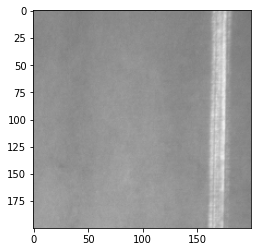

In [43]:
annotation = '/content/drive/My Drive/NEU-DET/ANNOTATIONS/scratches_37.xml'
image_path="/content/drive/My Drive/NEU surface defect database - test split/Test/Sc/Sc_37.bmp"

img = image.load_img(image_path, target_size=(200,200,3))
b_img = cv2.imread(image_path)
plt.grid(None)
plt.imshow(img)
plt.grid(None)

img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img /= 255
result = saved_model.predict(img)

prediction = result.argmax(axis=1)
print("Predicted class : ",prediction)
output = labels[int(prediction)]

print("Output : ",output)

GT Annotations :  [[156, 1, 183, 200]]


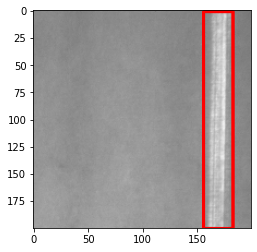

In [44]:
def extract_boxes(filename):
	tree = ElementTree.parse(filename)
	root = tree.getroot()	
	boxes = list()
	for box in root.findall('.//bndbox'):
		xmin = int(box.find('xmin').text)
		ymin = int(box.find('ymin').text)
		xmax = int(box.find('xmax').text)
		ymax = int(box.find('ymax').text)
		coors = [xmin, ymin, xmax, ymax]
		boxes.append(coors)
	return boxes 

boxes = extract_boxes(annotation)
print("GT Annotations : ",boxes)

for i in range(len(boxes)):
  pt1 = boxes[i][0], boxes[i][1]
  pt2 = boxes[i][2], boxes[i][3]
  cv2.rectangle(b_img, pt1, pt2, (255, 0, 0), 2)
  plt.imshow(b_img)

In [0]:
!pip install lime

In [24]:
%load_ext autoreload
%autoreload 2

import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime

from lime import lime_image

explainer = lime_image.LimeImageExplainer()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
%%time

# Hide color is the color for a superpixel turned OFF. 
# Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels

explanation = explainer.explain_instance(img[0], saved_model.predict, top_labels=6, hide_color=0)

print("Predictions:")
for i in range(len(explanation.top_labels)):
  rank = explanation.top_labels[i]
  print(i,':',labels[rank]) 

Predictions:
0 : Scratches
1 : Rolled-in Scale
2 : Inclusion
3 : Patches
4 : Crazing
5 : Pitted Surface
CPU times: user 4.21 s, sys: 701 ms, total: 4.91 s
Wall time: 4.92 s


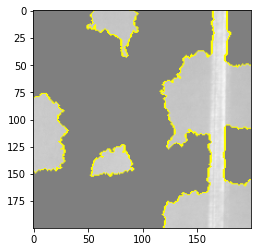

In [50]:
# hide_rest = False  ## -> not to show gray areas on image
# positive_only = True ## -> to show regions against the prediction -> displayed in 'red'

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

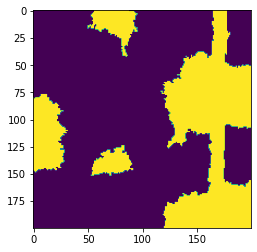

In [49]:
plt.imshow(mask)    # Plot the explanation mask
plt.show()

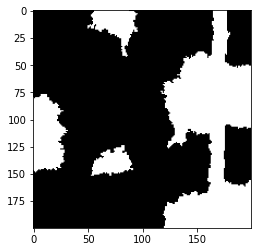

In [52]:
lime_mask = np.zeros(b_img.shape)
for i in range((img.shape)[1]):
  for j in range((img.shape)[2]):
    if mask[i][j] == 1:
      lime_mask[i][j] = 1
    else:
      lime_mask[i][j] = 0

plt.imshow(lime_mask)
plt.show()

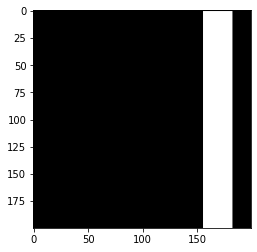

In [54]:
gt_mask = np.zeros(b_img.shape)

for l in range(len(boxes)):
  for i in range(boxes[l][1], boxes[l][3]):
    for j in range(boxes[l][0], boxes[l][2]):
      gt_mask[i][j] = 1 

plt.imshow(gt_mask)
plt.show()

In [55]:
intersection = np.logical_and(gt_mask, lime_mask)
union = np.logical_or(gt_mask, lime_mask)

iou_score = np.sum(intersection) / np.sum(union)
print("LIME IOU: ",round(iou_score, 3))

LIME IOU:  0.302


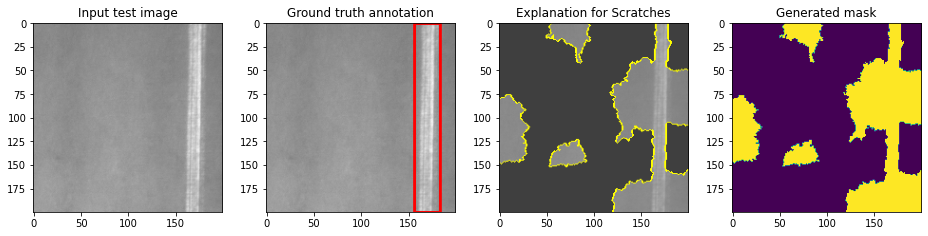

In [58]:
p = 0

temp, mask = explanation.get_image_and_mask(explanation.top_labels[p], positive_only=True, 
                                            num_features=10, hide_rest=True)
top = labels[explanation.top_labels[p]]
title = "Explanation for " + top

plt.figure(figsize=(16, 16))
plt.subplot(4,4,1)
plt.imshow(img[0])
plt.grid(None)
plt.title('Input test image')
plt.grid(None)

plt.subplot(4,4,2)
plt.imshow(b_img)
plt.grid(None)
plt.title('Ground truth annotation')
plt.grid(None)

plt.subplot(4,4,3)
plt.imshow(mark_boundaries(temp / 2 + 0.25, mask))
plt.grid(None)
plt.title(title)
plt.grid(None)

plt.subplot(4,4,4)
plt.imshow(mask)
plt.grid(None)
plt.title('Generated mask')
plt.grid(None)

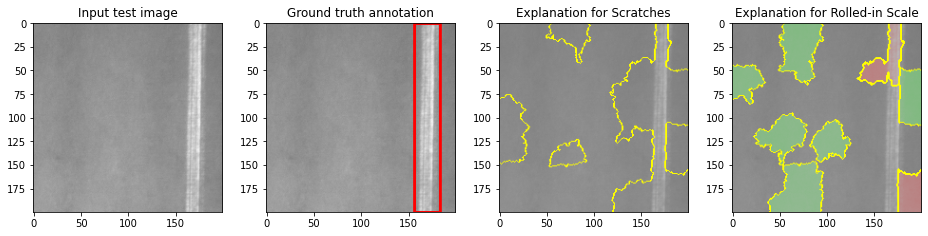

In [64]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, 
                                            num_features=10, hide_rest=False)
top = labels[explanation.top_labels[p]]
title = "Explanation for " + top

plt.figure(figsize=(16, 16))
plt.subplot(4,4,1)
plt.imshow(img[0])
plt.grid(None)
plt.title('Input test image')
plt.grid(None)

plt.subplot(4,4,2)
plt.imshow(b_img)
plt.grid(None)
plt.title('Ground truth annotation')
plt.grid(None)

plt.subplot(4,4,3)
plt.imshow(mark_boundaries(temp / 2 + 0.25, mask))
plt.grid(None)
plt.title(title)
plt.grid(None)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, 
                                            num_features=10, hide_rest=False)

plt.subplot(4,4,4)
plt.imshow(mark_boundaries(temp / 2 + 0.25, mask))
plt.grid(None)
plt.title('Explanation for Rolled-in Scale')
plt.grid(None)

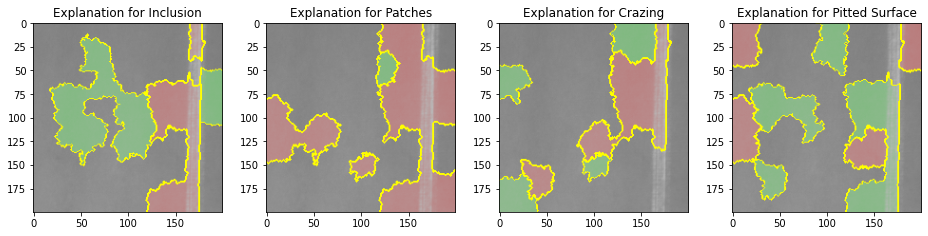

In [65]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[2], positive_only=False, 
                                            num_features=10, hide_rest=False)

plt.figure(figsize=(16, 16))
plt.subplot(4,4,1)
plt.imshow(mark_boundaries(temp / 2 + 0.25, mask))
plt.grid(None)
plt.title('Explanation for Inclusion')
plt.grid(None)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[3], positive_only=False, 
                                            num_features=10, hide_rest=False)
plt.subplot(4,4,2)
plt.imshow(mark_boundaries(temp / 2 + 0.25, mask))
plt.grid(None)
plt.title('Explanation for Patches')
plt.grid(None)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[4], positive_only=False, 
                                            num_features=10, hide_rest=False)
plt.subplot(4,4,3)
plt.imshow(mark_boundaries(temp / 2 + 0.25, mask))
plt.grid(None)
plt.title('Explanation for Crazing')
plt.grid(None)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[5], positive_only=False, 
                                            num_features=10, hide_rest=False)
plt.subplot(4,4,4)
plt.imshow(mark_boundaries(temp / 2 + 0.25, mask))
plt.grid(None)
plt.title('Explanation for Pitted Surface')
plt.grid(None)

# mIOU

In [0]:
!pip install lime

In [0]:
# NOTE: CHANGE INPUTS HERE

# x = {0: 'Crazing', 1: 'Inclusion', 2: 'Pitted Surface', 3: 'Patches', 4: 'Rolled-in Scale', 5: 'Scratches'}
x = 3

In [0]:
path_ROOT = '/content/drive/My Drive/NEU surface defect database - test split/Test/'

path_Cr = path_ROOT+'Cr'
path_In = path_ROOT+'In'
path_PS = path_ROOT+'PS'
path_Pa = path_ROOT+'Pa'
path_RS = path_ROOT+'RS'
path_Sc = path_ROOT+'Sc'

gt_path_ROOT = '/content/drive/My Drive/NEU surface defect database - test split/GT Test_2/'

gt_path_Cr = gt_path_ROOT+'Cr'
gt_path_In = gt_path_ROOT+'In'
gt_path_PS = gt_path_ROOT+'PS'
gt_path_Pa = gt_path_ROOT+'Pa'
gt_path_RS = gt_path_ROOT+'RS'
gt_path_Sc = gt_path_ROOT+'Sc'

In [0]:
test_path_list = [path_Cr, path_In, path_PS, path_Pa, path_RS, path_Sc]
gt_path_list = [gt_path_Cr, gt_path_In, gt_path_PS, gt_path_Pa, gt_path_RS, gt_path_Sc]

path = test_path_list[x]
# Idx = x
gt_path = gt_path_list[x]

In [0]:
test_files = []
for r, d, f in os.walk(path):
  for file in f:
    if '.bmp' in file:
      test_files.append(os.path.join(r, file))

gt_files = []
for r, d, f in os.walk(gt_path):
  for file in f:
    if '.bmp' in file:
      gt_files.append(os.path.join(r, file))

In [0]:
%load_ext autoreload
%autoreload 2

import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
%%time

labels = {0: 'Crazing', 1: 'Inclusion', 2: 'Pitted Surface', 3: 'Patches', 4: 'Rolled-in Scale', 5: 'Scratches'}
intersection = []
union = []

for ttf in range(len(test_files)):
  pop = os.path.basename(test_files[ttf])
  for gtf in range(len(gt_files)):
    if pop in gt_files[gtf]:

      # print(test_files[ttf])
      lime_test = image.load_img(test_files[ttf])
      # b_img = cv2.imread(test_files[ttf])
      lime_test = image.img_to_array(lime_test)
      lime_test = np.expand_dims(lime_test, axis = 0)
      lime_test /= 255

      explanation = explainer.explain_instance(lime_test[0], saved_model.predict, top_labels=6, hide_color=0)
      
      # print("Predictions:")
      # for i in range(len(explanation.top_labels)):
      #   rank = explanation.top_labels[i]
      #   print(i,':',labels[rank])

      temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
      # plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
      
      lime_mask = np.zeros(lime_test.shape[1:])
      for i in range((lime_test.shape)[1]):
        for j in range((lime_test.shape)[2]):
          if mask[i][j] == 2:
            lime_mask[i][j] = 255
          else:
            lime_mask[i][j] = 0
      # plt.imshow(lime_mask)

      # print(gt_files[gtf])
      grnd_truth = image.load_img(gt_files[gtf])  
      grnd_truth = image.img_to_array(grnd_truth)

      intrxn = np.logical_and(grnd_truth, lime_mask)
      intersection.append(intrxn)

      unn = np.logical_or(grnd_truth,lime_mask)
      union.append(unn)

miou_score = np.sum(intersection) / np.sum(union)
print("mIOU : ",miou_score)

mIOU :  0.221582018692723
CPU times: user 1min 34s, sys: 12.2 s, total: 1min 46s
Wall time: 1min 39s



#mIOU for LIME:

Crazing : 0.28

Inclusion : 0.2022

Pitted Surface : 0.1746

Patches : 0.2285

Rolled-in Scale : 0.1781

Scratches : 0.2248